<a href="https://www.kaggle.com/code/ernestbeardlypani/icr-identifying-age-related-conditions-eda?scriptVersionId=137362912" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Initializations

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr/pip-packages
Processing /kaggle/input/pip-packages-icr/pip-packages/tabpfn-0.1.9-py3-none-any.whl


In [2]:
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import numpy as np
import pickle
import gc
import random

In [3]:
import sys

# Import utility scripts folder
script_path = '/kaggle/usr/lib/tools/'
sys.path.append(script_path)

from borutashap import *
from automatedfeatureengineering import AutomatedFeatureEngineering

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
import sklearn.preprocessing as pp #import StandardScaler, FunctionTransformer, MinMaxScaler
#from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.decomposition as dc
from sklearn.metrics import make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.compose import make_column_transformer

In [5]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf

In [6]:
from tpot import TPOTClassifier
import sklearn.ensemble as es
import sklearn.model_selection as ms

In [7]:
open('tools.py', 'w').write('''
import sklearn.preprocessing as pp
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
import numpy as np
from tabpfn import TabPFNClassifier

class TabPFNClassifier2(TabPFNClassifier):
    def fit(self, X, y, **kwargs):
        super().fit(X, y, overwrite_warning=True, **kwargs)
        
class ModelWrapper(BaseEstimator):
    __sklearn_is_fitted__ = lambda: True
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y=None, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        p0 = probabilities[:,:1]
        p0[p0 > 0.86] = 1
        p0[p0 < 0.14] = 0
        y_p = np.empty((len(p0),))
        for i in range(len(p0)):
            if p0[i]>=0.5:
                y_p[i]= False
            else :
                y_p[i]=True
        return y_p.astype(int)
        
    def predict_proba(self, X):
        averaged_probabilities = self.model.predict_proba(X)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        y_pred = new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1) 
        probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
        return probabilities
        
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fitted = False

    def fit(self, X, y=None):
        if self.fitted:
            return self
        
        Q1 = np.quantile(X, q=0.25, axis=0)
        Q3 = np.quantile(X, q=0.75, axis=0)
        IQR = Q3 - Q1
        
        self.lower = Q1-10*IQR
        self.upper = Q3+10*IQR
        
        self.fitted = True
        return self

    def transform(self, X):
        X = self.lower*(X<self.lower)+X*(X>=self.lower)
        X = self.upper*(X>self.upper)+X*(X<=self.upper)
        return X

class Preprocessor(TransformerMixin):
    def __init__(self):
        self.preprocessor = make_pipeline(
            IterativeImputer(random_state=1),
            OutlierHandler(),
            pp.PowerTransformer(standardize=False)
        )

    def fit(self, X, y=None):
        self.preprocessor.fit(X, y)
        return self

    def transform(self, X):
        return self.preprocessor.transform(X)

    def fit_transform(self, X, y=None):
        return self.preprocessor.fit_transform(X, y)
''')

from tools import *

# Load data

In [8]:
train_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

In [9]:
features = [n for n in train_df.columns if n not in ['Id', 'Class', 'Alpha']]
extra_features = ['Epsilon']

In [10]:
alpha = greeks[["Id", "Alpha"]].copy()
alpha["Alpha"] = pp.LabelEncoder().fit_transform(alpha["Alpha"]).astype("int")

train_df = pd.merge(train_df, alpha, on='Id', sort=True)

## Split dataset into train, valid, and test datasets

In [11]:
train_df, remainder = train_test_split(train_df, 
                                       test_size=0.2, 
                                       random_state=1,
                                       stratify=train_df["Alpha"])

# Splitting the remaining data into validation and test sets
valid_df, test_df = train_test_split(remainder, 
                                     test_size=0.5, 
                                     random_state=1,
                                     stratify=remainder["Alpha"])

del remainder
gc.collect()

48

In [12]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha
354,8b77f91fde3e,0.457211,3718.79222,85.200147,24.162794,8.138688,5.288823,0.025578,9.717684,5.010964,...,1.67736,0.636662,39.412574,312.189143,21982.48178,48.618586,55.928140,21.978000,0,0
121,3026974712cd,1.140891,1649.24331,170.365458,59.549116,10.545684,8.717256,0.151032,10.272260,8.352778,...,1.52685,0.568932,20.696950,72.611063,14796.29503,44.116176,33.716348,0.079595,0,0
591,f404680da866,0.132463,1374.05664,85.200147,12.127852,8.138688,2.693136,0.025578,3.396778,5.228832,...,0.49706,1.530698,19.227234,72.611063,37706.52190,41.801714,42.247672,21.978000,0,0
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.49706,0.568932,9.292698,72.611063,27981.56275,29.135430,32.131996,21.978000,0,0
203,4f17ecd66363,0.529852,3971.08932,85.200147,25.448049,8.138688,5.306541,0.025578,14.853814,5.524008,...,2.95394,0.541840,19.673730,72.611063,8747.65008,44.663163,111.529636,0.205200,0,0


# EDA

In [13]:
print(f"Num. features: {len(features)}")
print(f"Num. train rows: {len(train_df)}")

Num. features: 56
Num. train rows: 493


## Data types

In [14]:
train_df.dtypes

Id        object
AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EJ        object
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
Alpha      int

Column EJ is of type "object". Lets check it out!

In [15]:
train_df["EJ"].unique()

array(['A', 'B'], dtype=object)

The column contains A and B values only. We can convert it to 0 and 1 with onehot encoding.

## Spaces in feature names
Spaces in feature names may cause errors.

In [16]:
colname_with_space = [col for col in train_df.columns if col.find(" ")!=-1]
colname_with_space

['BD ', 'CD ', 'CW ', 'FD ']

Its a good practice to remove the trailing space in column name to prevent errors.

## Is data normalized?

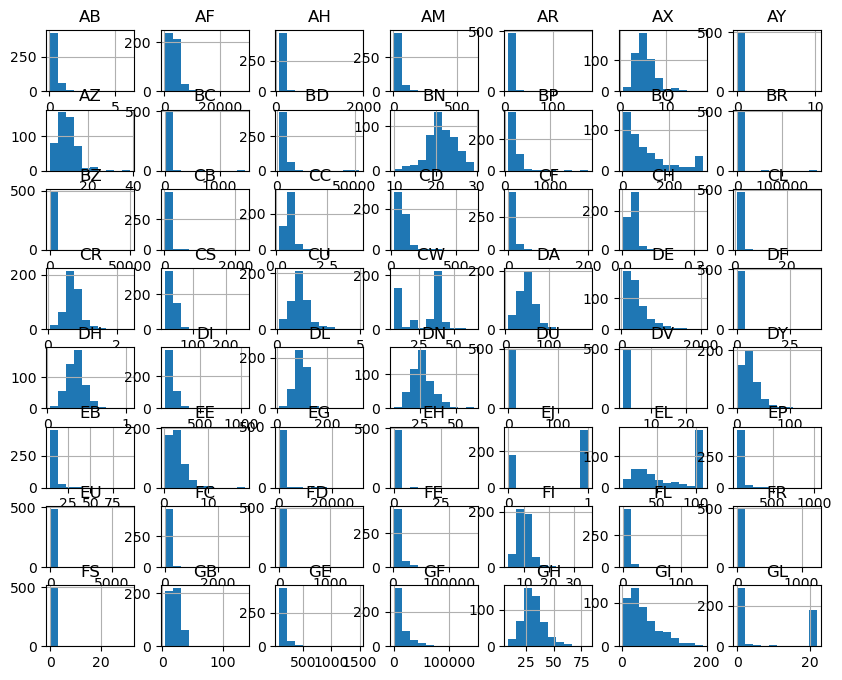

In [17]:
train_df[features].replace({'A': 0, 'B': 1}).hist(figsize=(10, 8))
plt.show()

The data is not normalized yet. Its a good practice to normalize the data first to boost performance.

## Imbalance data

In [18]:
print(train_df["Alpha"].value_counts())

0    407
1     49
3     23
2     14
Name: Alpha, dtype: int64


The amount of class is not balanced, and there is not much data.

## Null values

In [19]:
len(train_df[train_df.isna().any(axis=1)])

55

There are NaN values in rows.

<Axes: >

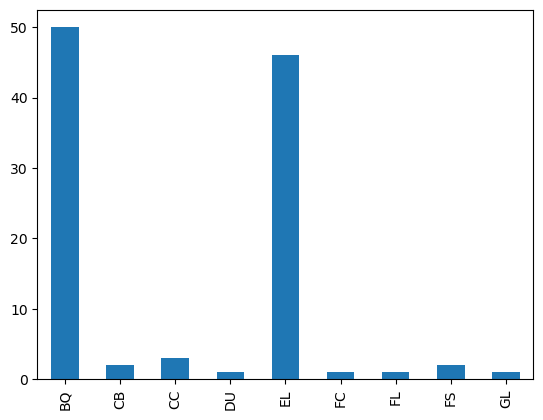

In [20]:
columns_with_na = train_df.apply(lambda x: len(x[x.isna()]), axis=0)
columns_with_na[columns_with_na>0].plot(kind="bar")

## Correlations

<Axes: >

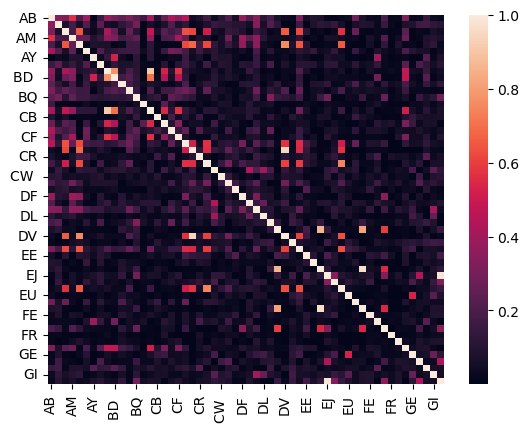

In [21]:
sns.heatmap(train_df[features].replace({'A': 0, 'B': 1}).corr().abs())

There are some highly correlated features. Feature selection is necessary.

## Outliers

In [22]:
scaled_df = train_df[features].replace({'A': 0, 'B': 1})
scaled_df = (scaled_df - scaled_df.mean(axis=0)) /  scaled_df.std(axis=0) 

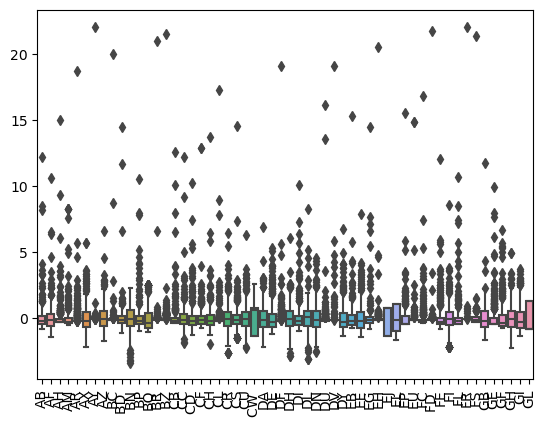

In [23]:
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)
plt.show()

Almost all features has outliers. Lets count the number of outliers in each columns. I will use the IQR method.

<Axes: >

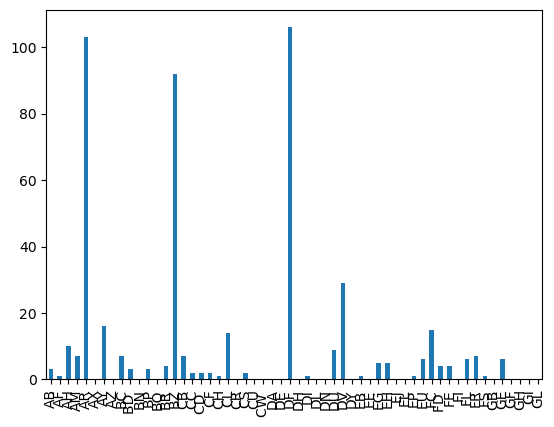

In [24]:
Q1 = scaled_df.quantile(0.25, axis=0)
Q3 = scaled_df.quantile(0.75, axis=0)
IQR = Q3 - Q1

outliers_count = scaled_df.apply(lambda x: len(x[((x<(Q1[x.name]-10*IQR[x.name])) | (x>(Q3[x.name]+10*IQR[x.name])))]), axis=0)
outliers_count.plot(kind="bar")

- Should we drop the columns with many (more than 10%) outliers?
- Should we drop the rows with outliers?
- Should we clip the values?

## Data processing todo list:
1. Remove trailing space in column names
2. Convert EJ column values from A and B to 0 and 1 respectively.
3. Handle NaN.
4. Handle outliers
5. Normalize dataset
6. Feature selection
7. Handle imbalance dataset

# Data processing

## 1. Remove trailing space in column names

In [25]:
train_df = train_df.rename(columns=lambda x: x.strip())
valid_df = valid_df.rename(columns=lambda x: x.strip())
test_df = test_df.rename(columns=lambda x: x.strip())
features = [n for n in train_df.columns if n not in ['Id', 'Class', 'Alpha', 'Epsilon']]

## 2. Convert EJ column values from A and B to 0 and 1 respectively

In [26]:
train_df["EJ"] = train_df["EJ"].replace({'A': 0, 'B': 1})
valid_df["EJ"] = valid_df["EJ"].replace({'A': 0, 'B': 1})
test_df["EJ"] = test_df["EJ"].replace({'A': 0, 'B': 1})
train_df["EJ"].head()

354    0
121    1
591    0
1      0
203    1
Name: EJ, dtype: int64

## 3. Handle NaN

### Create new_df for experimental dataset

In [27]:
new_df = train_df.copy()

### Impute data

In [28]:
imputer = SimpleImputer(strategy='mean')
new_df[features] = imputer.fit_transform(new_df[features])

In [29]:
len(new_df[features][new_df[features].isna().any(axis=1)])

0

## 4. Handle outliers

### Count extreme outliers in each columns.

<Axes: >

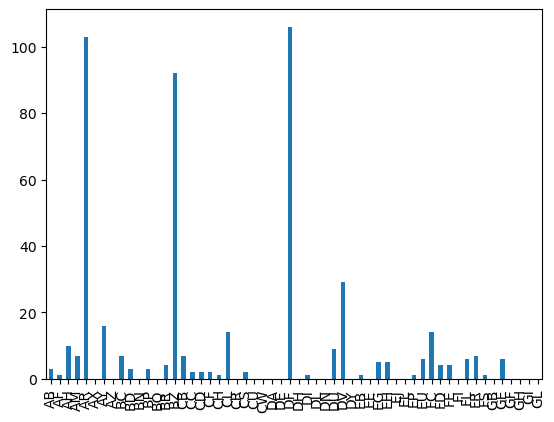

In [30]:
Q1 = new_df[features].quantile(0.25, axis=0)
Q3 = new_df[features].quantile(0.75, axis=0)
IQR = Q3 - Q1
outliers_count = new_df[features].apply(lambda x: len(x[((x<(Q1[x.name]-10*IQR[x.name])) | (x>(Q3[x.name]+10*IQR[x.name])))]), axis=0)
outliers_count.plot(kind="bar")

## Handling extreme outliers

### Delete features with more than 10% outliers

In [31]:
to_remove = outliers_count[outliers_count/len(train_df)>.1]
to_remove

AR    103
BZ     92
DF    106
dtype: int64

In [32]:
good_features = list(set(features) - set(to_remove.index))
good_features.sort()

### Handling the rest

In [33]:
outlier_handler = OutlierHandler()
new_df[good_features] = outlier_handler.fit_transform(new_df[good_features])

## Count extreme outliers after handled

<Axes: >

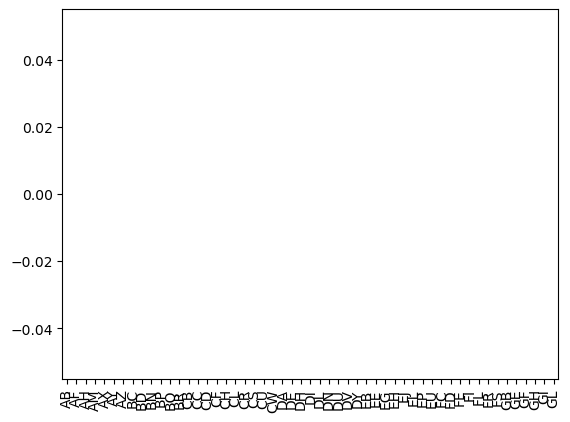

In [34]:
Q1 = new_df[good_features].quantile(0.25, axis=0)
Q3 = new_df[good_features].quantile(0.75, axis=0)
IQR = Q3 - Q1
outliers_count = new_df[good_features].apply(lambda x: len(x[((x<(Q1[x.name]-10*IQR[x.name])) | (x>(Q3[x.name]+10*IQR[x.name])))]), axis=0)
outliers_count.plot(kind="bar")

### Some features become a constant ofter handling outliers. Delete this features

In [35]:
const_features = new_df[good_features].apply(lambda x: x.min()==x.max(), axis=0)
const_features = const_features[const_features].index
const_features

Index(['DV'], dtype='object')

In [36]:
good_features = list(set(good_features) - set(const_features))
good_features.sort()

## 5. Normalize dataset

For the normalization method, I will use the power_transform method.

In [37]:
to_normalize = list(set(good_features) - set(["EJ"]))

In [38]:
normalizer = pp.PowerTransformer(standardize=False)
new_df[to_normalize] = normalizer.fit_transform(new_df[to_normalize])

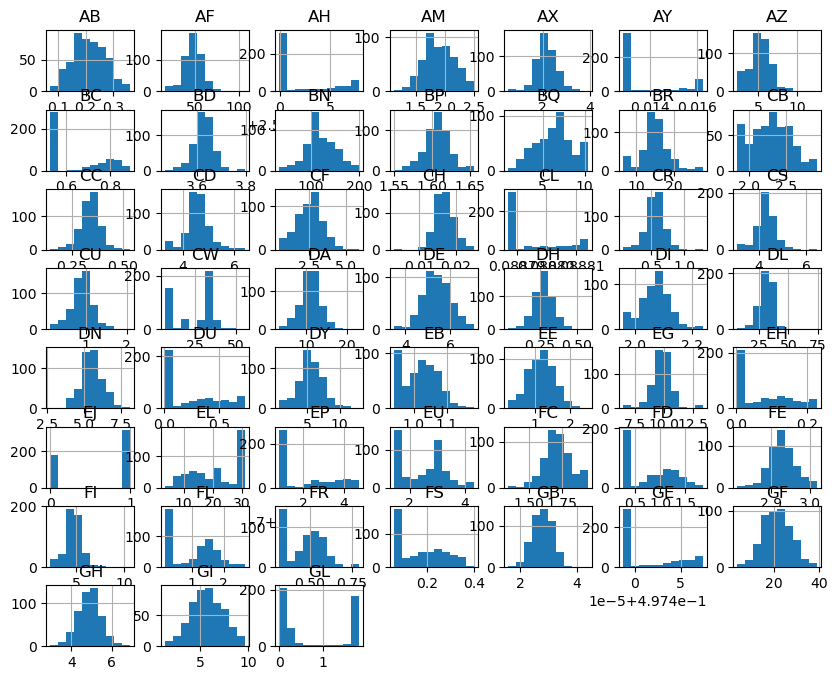

In [39]:
new_df[good_features].hist(figsize=(10, 8))
plt.show()

## 6. Feature selection

### List some highly correlated features

In [40]:
correlation_matrix = train_df[good_features].corr().abs()
high_correlation = correlation_matrix.unstack().sort_values(ascending=False)
high_correlation = high_correlation[(high_correlation>0.9) & (high_correlation!=1)].drop_duplicates()
high_correlation = list(high_correlation.index)
highly_correlated_features = list(set([item for sublist in high_correlation for item in sublist]))
high_correlation

[('EJ', 'GL'), ('FD', 'EH')]

### Investigate each features

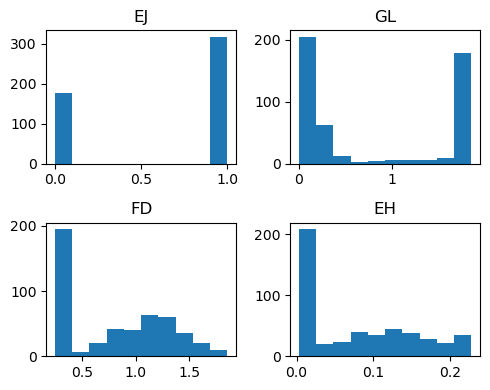

In [41]:
fig, axs = plt.subplots(len(high_correlation), 2, figsize=(5, 2*len(high_correlation)))

for i, (col1, col2) in enumerate(high_correlation):
    axs[i, 0].hist(new_df[col1])
    axs[i, 0].set_title(f'{col1}')
    axs[i, 1].hist(new_df[col2])
    axs[i, 1].set_title(f'{col2}')

plt.tight_layout()
plt.show()

In [42]:
new_df[["EJ", "GL", "Alpha"]].corr().abs()["Alpha"].sort_values(ascending=False)

Alpha    1.000000
EJ       0.045174
GL       0.011105
Name: Alpha, dtype: float64

Deleting GL column because EJ column is more correlated with the target.

In [43]:
new_df[["EH", "FD", "Alpha"]].corr().abs()["Alpha"].sort_values(ascending=False)

Alpha    1.000000
FD       0.034393
EH       0.029653
Name: Alpha, dtype: float64

Deleting EH column because FD column is more correlated with the target.

In [44]:
good_features = list(set(good_features) - set(['GL', 'EH']))
len(good_features)

50

<Axes: >

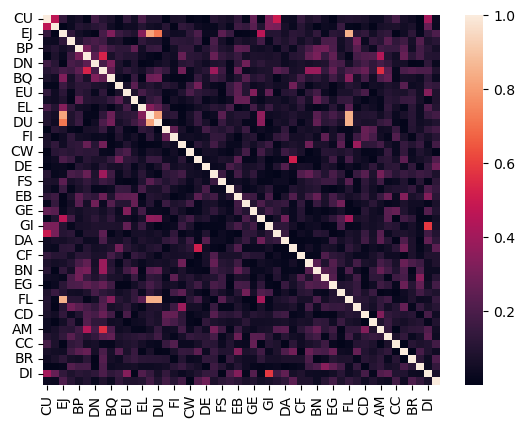

In [45]:
sns.heatmap(new_df[good_features].corr().abs())

## 7. Handle imbalance dataset

I will use oversampling method to handle imbalance data.

In [46]:
ros = RandomOverSampler(random_state=200)

new_df, y_alpha = ros.fit_resample(new_df, new_df["Alpha"])

In [47]:
print(new_df["Alpha"].value_counts())

0    407
2    407
1    407
3    407
Name: Alpha, dtype: int64


### Save custom good features

In [48]:
with open(f'good_features.pkl', 'wb') as f:
    pickle.dump(good_features, f)

# Model Selection

## Prepare training data

In [49]:
#ros = RandomOverSampler(random_state=1)
#train_df, y_alpha = ros.fit_resample(train_df, train_df["Alpha"])

## Model maker

In [50]:
class Preprocessor(TransformerMixin):
    def __init__(self):
        self.sampler = RandomOverSampler(random_state=1)
        self.preprocessor = make_pipeline(
            SimpleImputer(strategy='mean'),
            OutlierHandler(),
            pp.PowerTransformer(standardize=False)
        )

    def fit(self, X, y=None):
        self.preprocessor.fit(X, y)
        return self
    
    def fit_resample(self, X, y):
        X = self.fit_transform(X)
        return self.sampler.fit_resample(X, y)

    def transform(self, X):
        return self.preprocessor.transform(X)

    def fit_transform(self, X, y=None):
        return self.preprocessor.fit_transform(X, y)

In [51]:
def make_model(preprocessor, estimator):
    return Pipeline([
        ("preprocessor", preprocessor),
        ("model", ModelWrapper(estimator))
    ])

## Competition loss function

In [52]:
# A weighted average log-loss - same as the competion LL but with
# an overall constant that varies with the class ratio.
# slightly modified from
# https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/409691
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

def balanced_log_loss_scorer(estimator, X, y_t):
    estimator = ModelWrapper(estimator)
    y_p = estimator.predict(X)
    y_t[y_t>0] = 1
    score = -balanced_log_loss(y_t, y_p)
    return score

## Pipeline Evaluator

In [53]:
def model_evaluator(X_train, y_train, X_valid, y_valid, process_data=True):
    models = [
        ("LogisticRegression", LogisticRegression(random_state=1)),
        ("SVC", SVC(probability=True, random_state=1)),
        ("RandomForestClassifier", RandomForestClassifier(random_state=1)),
        ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=1)),
        ('HistGradientBoostingClassifier', HistGradientBoostingClassifier(random_state=1)),
        ('XGBClassifier', XGBClassifier(random_state=1)),
        ('LGBMClassifier', LGBMClassifier(random_state=1)),
        ('CatBoostClassifier', CatBoostClassifier(random_state=1, verbose=0)),
        ('KNeighborsClassifier', KNeighborsClassifier()),
        ("GaussianNB", GaussianNB()),
        ("TabPFNClassifier", TabPFNClassifier2())
    ]

    model_scores = {}
    for name, estimator in models:
        if process_data:
            preprocessor = Preprocessor()
            X, y = preprocessor.fit_resample(X_train, y_train)
            model = ModelWrapper(estimator)
            model.fit(X, y)
            model = make_model(preprocessor, estimator)
            
        else:
            model = ModelWrapper(make_pipeline(SimpleImputer(strategy='mean'), estimator))
            model.fit(X_train, y_train)
            
        score = balanced_log_loss_scorer(model, X_valid, y_valid.copy())
        model_scores[name] = -score
    
    return model_scores

# Model Selection

In [54]:
X_train, y_train = train_df[features].copy(), train_df["Alpha"].copy()
X_valid, y_valid = valid_df[features].copy(), valid_df["Alpha"].copy()
up_model_scores = model_evaluator(X_train, y_train, X_valid, y_valid, process_data=False)

X_train, y_train = train_df[good_features].copy(), train_df["Alpha"].copy()
X_valid, y_valid = valid_df[good_features].copy(), valid_df["Alpha"].copy()
fs_model_scores = model_evaluator(X_train, y_train, X_valid, y_valid, process_data=False)
p_model_scores = model_evaluator(X_train, y_train, X_valid, y_valid, process_data=True)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


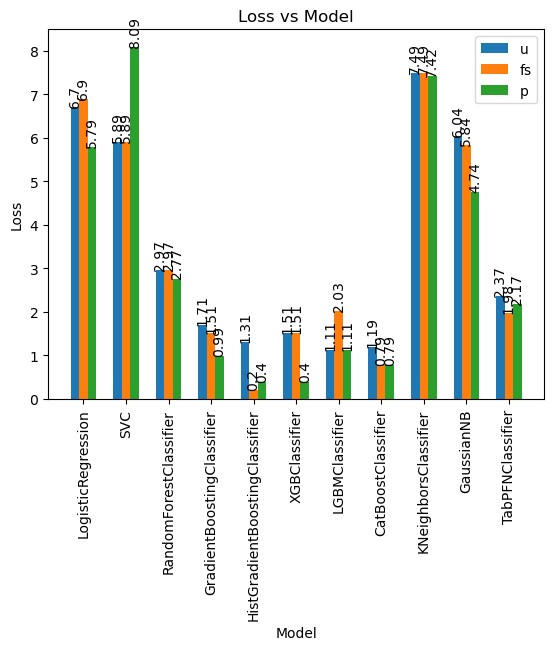

In [55]:
score_x = up_model_scores.keys()
score_y0 = up_model_scores.values()
score_y1 = fs_model_scores.values()
score_y2 = p_model_scores.values()

x = np.arange(len(score_x))
width = 0.2
plt.bar(x-1*width, score_y0, width=width, label='u')
plt.bar(x+0*width, score_y1, width=width, label='fs')
plt.bar(x+1*width, score_y2, width=width, label='p')

for i, (v0,v1,v2) in enumerate(zip(score_y0,score_y1,score_y2)):
    plt.text(i-1*width, v0, str(round(v0,2)), ha='center', va='bottom', rotation=90)
    plt.text(i+0*width, v1, str(round(v1,2)), ha='center', va='bottom', rotation=90)
    plt.text(i+1*width, v2, str(round(v2,2)), ha='center', va='bottom', rotation=90)

# Add labels, title, and legend
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss vs Model')
plt.xticks(x, score_x, rotation=90)
#plt.figure(figsize=(8, 6), num=1)
plt.legend()
plt.show()

up: Unprocessed data

fs: Feature selection only

p: Processed data including feature selection

- Most model performs well when trained on selected features. This indicades that the selected features are good features.
- The top 3 models are LGBMClassifier, HistGradientBoostingClassifier, and XGBClassifier.
- LGBMClassifier preforms best on p, HistGradientBoostingClassifier performs best on fs, and XGBClassifier performs the same on p and fs.

### Next steps:
- Do hyperparameter tuning on XGBClassifier, LGBMClassifier, CatBoostClassifier, and RandomForestClassifier models.
- Ensemble models

# Hyperparameter Tuning

In [56]:
from deap import base, creator, tools, algorithms

# Create types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

## Useful functions

In [57]:
def get_params(individual, config_dict):
    params = {key: individual[i] for i, key in enumerate(config_dict.keys())}
    return params

def mutate(individual, config_dict, indpb=.1):
    for i, key in enumerate(config_dict.keys()):
        if random.random() < indpb:
            individual[i] = random.choice(config_dict[key])
        
    return individual,

def evaluate_individual(individual, preprocessor, estimator_class, config_dict, X, y, X_valid, y_valid):
    # Prepare model
    params = get_params(individual, config_dict)
    estimator = estimator_class(**params)
    model = ModelWrapper(estimator)
    
    # Fit model
    extra_fit_params = {}
    if estimator_class == LGBMClassifier:
        extra_fit_params = {
            'callbacks': [log_evaluation(-1, False)]
        }
            
    else:
        extra_fit_params = {
            'verbose': 0
        }
    
    try:
        model.fit(X, y, **extra_fit_params)
        model = make_model(preprocessor, estimator)

        # Get score
        score = balanced_log_loss_scorer(model, X_valid, y_valid)
    except:
        score = -100.0
        
    return score,

In [58]:
def search_best_params(
        estimator_class,
        config_dict,
        X_train, y_train,
        X_valid, y_valid,
        npop = 10, # number of population
        ngen = 10, # number of generations
        mutpb = .9, # mutation probability
        cxpb = .1 # Mating probability
    ):
    
    preprocessor = Preprocessor()
    X, y = preprocessor.fit_resample(X_train, y_train)
    
    # Initialize genetic algorithm components
    toolbox = base.Toolbox()
    attrs = []
    for key, value in config_dict.items():
        toolbox.register(f'attr_{key}', random.choice, value)
        attrs.append(eval(f'toolbox.attr_{key}'))
    toolbox.register("individual", tools.initCycle, creator.Individual, tuple(attrs), n=1)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register genetic operators
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutate, config_dict=config_dict, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    toolbox.register("evaluate", 
                     evaluate_individual, 
                     estimator_class=estimator_class,
                     preprocessor=preprocessor, 
                     config_dict=config_dict,
                     X=X, y=y, 
                     X_valid=X_valid,
                     y_valid=y_valid)

    # Set up the genetic algorithm
    population = toolbox.population(n=npop)
    hof = tools.HallOfFame(10)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Run the genetic algorithm
    pop, logbook = algorithms.eaSimple(population, 
                                       toolbox, 
                                       cxpb=cxpb, 
                                       mutpb=mutpb, 
                                       ngen=ngen, 
                                       stats=stats, 
                                       halloffame=hof, 
                                       verbose=True)

    # Get best params
    best_params = get_params(hof[0], config_dict)
    print(f"Best params:", best_params)
    return best_params

In [59]:
def get_best_params():
    random_state = 1
    random.seed(random_state)
    
    config_dicts = {
        CatBoostClassifier: {
            'n_estimators': [50,100,200,400],
            'colsample_bylevel': np.arange(0.1,1.0,0.1), 
            'learning_rate':np.arange(0.002,0.4,0.02), 
            'max_depth':[3,4,5,6,7,8,9,10],
            'objective':["MultiClass", "MultiClassOneVsAll"], 
            'model_size_reg':[0,1,2,3,4,5,6], 
            'reg_lambda':[0,1,2,3,4,5,6], 
            'verbose':[0],
            #'task_type': ["GPU"],
            'random_seed':[random_state]
        },
        XGBClassifier: {
            'n_estimators': [50,100,200,400,800,1600],
            'colsample_bytree': np.arange(0.1,1.0,0.1), 
            'learning_rate':np.arange(0.002,0.4,0.002), 
            'max_depth':[3,4,5,6,7,8,9,10],
            'objective':["multi:softmax", "multi:softprob"], 
            'reg_alpha':[0,1,2,3,4,5,6], 
            'reg_lambda':[0,1,2,3,4,5,6],
            #'tree_method':['gpu_hist'],
            'random_state':[random_state]
        },
        LGBMClassifier: {
            'n_estimators': [50,100,200,400,800,1600],
            'learning_rate': np.arange(0.002, 0.4, 0.02),
            'max_depth': [-1, 3, 4, 5, 6, 7, 8, 9, 10],
            'num_leaves': [31, 50, 100, 200, 300],
            'boosting_type': ['gbdt', 'dart', 'goss'],
            'subsample': np.arange(0.1, 1.0, 0.1),
            'colsample_bytree': np.arange(0.1, 1.0, 0.1),
            'reg_alpha': [0, 1, 2, 3, 4, 5, 6],
            'reg_lambda': [0, 1, 2, 3, 4, 5, 6],
            'n_jobs': [-1],
            'random_state': [random_state],
        },
    }
    
    best_params = {}
    for estimator_class, config_dict in config_dicts.items():
        best_params[estimator_class] = search_best_params(
            estimator_class,
            config_dict,
            X_train.values, y_train.values,
            X_valid.values, y_valid.values,
            npop = 100,
            ngen = 10,
            mutpb = .9,
            cxpb = .1
        )
    
    return best_params

In [60]:
best_params = get_best_params()
best_xgb = best_params[XGBClassifier]
best_lgb = best_params[LGBMClassifier]
best_cat = best_params[CatBoostClassifier]

gen	nevals	avg     	min 	max      
0  	100   	-5.82366	-100	-0.395354
1  	93    	-1.52984	-2.96516	-0.395354
2  	92    	-2.27789	-100    	-0.395354
3  	91    	-1.04481	-2.17445	-0.395354
4  	87    	-1.94058	-100    	-0.395354
5  	91    	-1.90769	-100    	-0.395354
6  	87    	-1.79484	-100    	-0.395354
7  	97    	-2.85181	-100    	-0.395354
8  	88    	-1.67821	-100    	-0.395354
9  	92    	-1.63418	-100    	-0.395354
10 	91    	-3.71128	-100    	-0.395354
Best params: {'n_estimators': 400, 'colsample_bylevel': 0.9, 'learning_rate': 0.26199999999999996, 'max_depth': 7, 'objective': 'MultiClass', 'model_size_reg': 6, 'reg_lambda': 1, 'verbose': 0, 'random_seed': 1}
gen	nevals	avg     	min     	max      
0  	100   	-1.88889	-3.68396	-0.593031
1  	92    	-1.44394	-3.28861	-0.395354
2  	93    	-1.15767	-2.17445	-0.593031
3  	84    	-0.919737	-2.37212	-0.395354
4  	87    	-0.839767	-3.09093	-0.395354
5  	93    	-0.725295	-2.30022	-0.395354
6  	93    	-0.678571	-2.37212	-0.395354
7  	92    	-

In [61]:
with open(f'best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

# Test the Final Model

In [62]:
def make_final_model(X_train, y_train):
    estimator = es.VotingClassifier([
        ("xgb_model", XGBClassifier(**best_xgb)),
        ("lgb_model", LGBMClassifier(**best_lgb)),
        ("cat_model", CatBoostClassifier(**best_cat))
    ], voting='soft', n_jobs=1)
    
    preprocessor = Preprocessor()
    X, y = preprocessor.fit_resample(X_train, y_train)
    model = ModelWrapper(estimator)
    model.fit(X, y)
    model = make_model(preprocessor, estimator)
    return model

In [63]:
model = make_final_model(X_train, y_train)

X_test, y_test = test_df[good_features].copy(), test_df["Alpha"].copy()
score = balanced_log_loss_scorer(model, X_test, y_test)
print(score)

-1.5814165907003115
